20200807_02

Kornpob Bhirombhakdi, kbhirombhakdi@stsci.edu

# Story
We would like to compute the aperture correction for HST grism extraction when performing on a drz-blot flt frame.

# Background
Aperture correction for original flt frame of HST grisms was presented in ISRs. However, this correction might not be the same when the reduction is performed on a drz-blot flt frame. Theoretically, we would expect drz-blot flt objects to have different PSFs. Therefore, additional correction should be necessary when performing grism reduction on drz-blot flt frame.

# Previously...
- 20200805: G102 of GD153 was shown. We will perform similar analysis here but with G141.
- 20200806: G102 of two stars (S03 and S02) in the field of GRB 190829A at epoch 202011XX (from proposal ID 15510) were analyzed.

# Data
GD153 from proposal ID 11552 has four G141 images at the central region.

# Code
Code primer can be fetched from 20200806.
    
# Objectives
- Derive aperture correction comparing between drzblot and crcorr.
- Apply the correction to GRB 190829A.
 

In [1]:
from hstgrism.container import Container
from hstgrism.confreader import ConfReader
from hstgrism.computesip import ComputeSIP
from hstgrism.computetracenwavelength import ComputeTraceNWavelength
from hstgrism.computexyref import ComputeXYREF
from hstgrism.wfc3irg141 import WFC3IRG141
from hstgrism.cutout2d import Cutout2D
from hstgrism.objectmask import ObjectMask
from hstgrism.flatfield import FlatField
from hstgrism.background import Background
from hstgrism.to_fullframe import to_fullframe
from hstgrism.grismapcorr import GrismApCorr
from hstgrism.show_overview import show_overview
from hstgrism.show_bbox import show_bbox
from hstgrism.show_sum1d import show_sum1d
from scipy.interpolate import interp1d
import numpy as np
import pandas as pd
from astropy.io import fits
import matplotlib.pyplot as plt
import copy,glob


In [2]:
from astropy.io import fits
import matplotlib.pyplot as plt

def show_dither(flist):
    """
    Plot dither pattern for diagnosis
    """
    fig = plt.figure()
    ax1 = fig.add_subplot(1,2,1)
    ax1.set_title('dither pattern',fontsize=12)
    ax2 = fig.add_subplot(1,2,2)
    ax2.set_title('reduced dither pattern',fontsize=12)
    for i,ii in enumerate(flist):
        scale = fits.open(ii)[1].header['IDCSCALE']
        px,py = fits.open(ii)[0].header['POSTARG1']/scale,fits.open(ii)[0].header['POSTARG2']/scale
        ax1.plot(px,py,'s')
        ax1.annotate(i,(px,py),
                     textcoords='offset points',
                     xytext=(0,10),
                     ha='center',
                     fontsize=12,
                     rotation=0.
                    )
        x,y = np.mod(px,1.),np.mod(py,1.)
        ax2.plot(x,y,'s')
        ax2.annotate(i,(x,y),
                     textcoords='offset points',
                     xytext=(0,10),
                     ha='center',
                     fontsize=12,
                     rotation=0.
                    )
    fig.tight_layout()
        

In [3]:
import numpy as np

def read_ds9region(ds9regfile):
    """
    Assume ds9regfile in the format as ds9, and coordinate system as image
    """
    out = {}
    f = open(ds9regfile,'r')
    for i,ii in enumerate(f.readlines()):
        if i < 3:
            continue
        x,y,_ = np.array(ii.split('(')[1].split(')')[0].split(',')).astype(float)
        z = ii.split('{')[1].split('}')[0]
        out[z] = (x,y)
    return out


In [15]:
from hstgrism.container import Container
from hstgrism.computetracenwavelength import ComputeTraceNWavelength
from hstgrism.computexyref import ComputeXYREF
from hstgrism.wfc3irg141 import WFC3IRG141
from hstgrism.cutout2d import Cutout2D
from hstgrism.flatfield import FlatField
from hstgrism.show_overview import show_overview
import pandas as pd
import os

def generate_flatfield_flt_g141(saveprefix,savefolder,plotformat,overwrite,
                           xyd,confile,beam,gfile,dfile,
                           flatfile,
                           params_overview
                          ):
    """
    Use hstgrism to make flatfielded grism flt.
    """
    ##########
    # Make Container
    ##########
    container_params = {'saveprefix':saveprefix,
                        'savefolder':savefolder,
                        'plotformat':plotformat,
                        'overwrite':overwrite
                       }
    containerobj = Container(**container_params)
    ##########
    # Compute xyref
    ##########
    xyref_params = {'xyd':xyd,
                    'xydiff':'default',
                    'xyoff':'default',
                    'confile':confile,
                    'beam':beam,
                    'gfile':gfile,
                    'dfile':dfile,
                    'container':containerobj
                   }
    xyrefobj = ComputeXYREF(**xyref_params)
    xyrefobj.compute()
    xyrefobj.save()
    ##########
    # Map trace and wavelength
    ##########
    xyref = xyrefobj.data['xyref']
    grism_params = {'confile':confile,
                    'beam':beam,
                    'xyref':xyref,
                    'container':containerobj
                   }
    grismobj = WFC3IRG141(**grism_params)
    grismobj.compute()
    grismobj.save()
    ##########
    # show_overview
    ##########
    show_overview(gfile,dfile,xyd,xyref,grismobj.output['xh'],grismobj.output['yh'],grismobj.output['ww'],
                  objname=containerobj.data['saveprefix'],
                  save=True,
                  container=containerobj,
                  params=params_overview
                 )    
    ##########
    # Make cutout
    ##########
    tfile = './{0}/{1}_trace.csv'.format(containerobj.data['savefolder'],containerobj.data['saveprefix'])
    tdata = pd.read_csv(tfile)
    xg = tdata.xh + tdata.xyref[0]
    yg = tdata.yh + tdata.xyref[1]
    halfdy = 20
    tbox = {'xg':xg,'yg':yg,'halfdyup':halfdy,'halfdylow':halfdy}
    bbox={'padxleft': 15, 'padxright': 15, 'padyup': 15, 'padylow': 15}
    image = fits.open(gfile[0])[gfile[1]].data
    do_mask = True
    cutoutobj = Cutout2D(tbox,bbox,image,containerobj)
    cutoutobj.compute(do_mask)
    cutoutobj.save()
    ##########
    # Make flatfield
    ##########
    tfile = './{0}/{1}_trace.csv'.format(containerobj.data['savefolder'],containerobj.data['saveprefix'])
    tdata = pd.read_csv(tfile)
    bbcorner = './{0}/{1}_bbcorner.csv'.format(containerobj.data['savefolder'],containerobj.data['saveprefix'])
    bbdata = pd.read_csv(bbcorner)
    flatobj = FlatField(container=containerobj,flatfile=flatfile,xyref=tdata.xyref,dldp=tdata.dldp)
    flatobj.compute()
    flatobj.save(do_cutout=False)
    ##########
    # Make flatfielded flt
    ##########
    string = './{0}/{1}'.format(containerobj.data['savefolder'],gfile[0].split('/')[-1])
    os.system('cp {0} {1}'.format(gfile[0],string))
    gfile_new = (string,1)
    ffile = ('./{0}/{1}_fullflat.fits'.format(containerobj.data['savefolder'],containerobj.data['saveprefix']),1)
    tmp = fits.open(gfile_new[0])
    tmpdata = tmp[gfile_new[1]].data.copy()
    flatdata = fits.open(ffile[0])[ffile[1]].data.copy()
    m = np.isfinite(flatdata)
    tmpdata[m] = tmpdata[m] / flatdata[m]
    tmp[gfile_new[1]].data = tmpdata.copy()
    tmp.writeto(gfile_new[0],overwrite=True)
    print('Update flatfielded {0}'.format(gfile_new[0]))


In [5]:
from astropy.io import fits

def bkgsub(gfile,bfile,container,savesuffix = 'sub'):
    """
    Perform bacgkground subtraction and save as ./savefolder/saveprefix_savesuffix.fits
    - savesuffix = 'sub' by default
    - output = gfile - bfile
    """
    savefolder = container.data['savefolder']
    saveprefix = container.data['saveprefix']
    gdata = fits.open(gfile[0])[gfile[1]].data
    bdata = fits.open(bfile[0])[bfile[1]].data
    sdata = gdata - bdata
    phdu = fits.PrimaryHDU()
    ihdu = fits.ImageHDU()
    hdul = fits.HDUList([phdu,ihdu])
    hdul[1].data = sdata
    string = './{0}/{1}_{2}.fits'.format(savefolder,saveprefix,savesuffix)
    hdul.writeto(string,overwrite=True)
    print('Save {0}'.format(string))
    

In [6]:
from hstgrism.container import Container
from hstgrism.confreader import ConfReader
from hstgrism.computesip import ComputeSIP
from hstgrism.computetracenwavelength import ComputeTraceNWavelength
from hstgrism.computexyref import ComputeXYREF
from hstgrism.wfc3irg102 import WFC3IRG102
from hstgrism.cutout2d import Cutout2D
from hstgrism.objectmask import ObjectMask
from hstgrism.flatfield import FlatField
from hstgrism.background import Background
from hstgrism.to_fullframe import to_fullframe
from hstgrism.grismapcorr import GrismApCorr
from hstgrism.show_overview import show_overview
from hstgrism.show_bbox import show_bbox
from hstgrism.show_sum1d import show_sum1d
from scipy.interpolate import interp1d
import numpy as np
import pandas as pd
from astropy.io import fits
import matplotlib.pyplot as plt
import copy,glob
from drizzlepac.astrodrizzle import AstroDrizzle
from drizzlepac import ablot


The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       config_testbed      imagefindpars           mapreg       
       photeq            pixreplace           pixtopix            pixtosky      
  refimagefindpars       resetbits          runastrodriz          skytopix      
     tweakback            tweakreg           updatenpol


# 1. Choose object, perform flatfield, generate crcorr and drzblot files

0 iab904meq F140W 55047.85297592 False -20.0 0.0 0.1282500028610229
1 iab904mgq G141 55047.85388999 False -20.0 0.0 0.1282500028610229
2 iab904mkq G141 55047.85579999 False -20.5 0.5 0.1282500028610229
3 iab904mlq G141 55047.85770962 False -21.0 1.0 0.1282500028610229
4 iab904mmq G141 55047.85961925 False -21.200001 1.2 0.1282500028610229


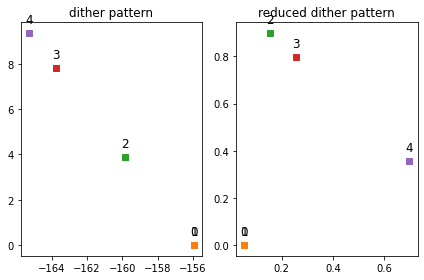

In [9]:
fpath = '/Users/kbhirombhakdi/_work/_data/11552/G141_set/mastDownload/HST'
tmp = np.array(glob.glob(fpath+'/*/*flt.fits'))
tlist = [tmp[6],tmp[10],tmp[1],tmp[3],tmp[9]]
for ii,i in enumerate(tlist):
    h = fits.open(i)[0].header
    hs = fits.open(i)[1].header
    string = '{0} {1} {2} {3} {4} {5} {6} {7}'.format(ii,h['ROOTNAME'],h['FILTER'],h['EXPSTART'],h['SUBARRAY'],
                       h['POSTARG1'],h['POSTARG2'],hs['IDCSCALE']
                      )
    print(string)
show_dither(tlist)
flist = copy.deepcopy(tlist)


In [24]:
sourcelist = {}
sourcename = 'GD153'
sourcelist[sourcename] = (352.51599, 546.3308)
confile = '/Users/kbhirombhakdi/_work/_calib_files/WFC3.IR.G141.cal.V4.32/G141.F140W.V4.32.conf'
flatfile = '/Users/kbhirombhakdi/_work/_calib_files/WFC3.IR.G141.cal.V4.32/WFC3.IR.G141.flat.2.fits'


Save ./iab904mgq_GD153/iab904mgq_GD153_xyref.csv
Rescale = False
Perform compute
Rescale = False
Perform compute
Rescale = False
Perform compute
Rescale = False
Perform compute
Save ./iab904mgq_GD153/iab904mgq_GD153_trace.csv
Save ./iab904mgq_GD153/iab904mgq_GD153_overview.pdf

Save ./iab904mgq_GD153/iab904mgq_GD153_tbox.csv
Save ./iab904mgq_GD153/iab904mgq_GD153_bbox.csv
Save ./iab904mgq_GD153/iab904mgq_GD153_bbcorner.csv
Save ./iab904mgq_GD153/iab904mgq_GD153_cutout.fits
Save ./iab904mgq_GD153/iab904mgq_GD153_mask.fits
Save ./iab904mgq_GD153/iab904mgq_GD153_fullflat.fits
Update flatfielded ./iab904mgq_GD153/iab904mgq_flt.fits
Save ./iab904mkq_GD153/iab904mkq_GD153_xyref.csv
Rescale = False
Perform compute
Rescale = False
Perform compute
Rescale = False
Perform compute
Rescale = False
Perform compute
Save ./iab904mkq_GD153/iab904mkq_GD153_trace.csv
Save ./iab904mkq_GD153/iab904mkq_GD153_overview.pdf

Save ./iab904mkq_GD153/iab904mkq_GD153_tbox.csv
Save ./iab904mkq_GD153/iab904mkq_GD15

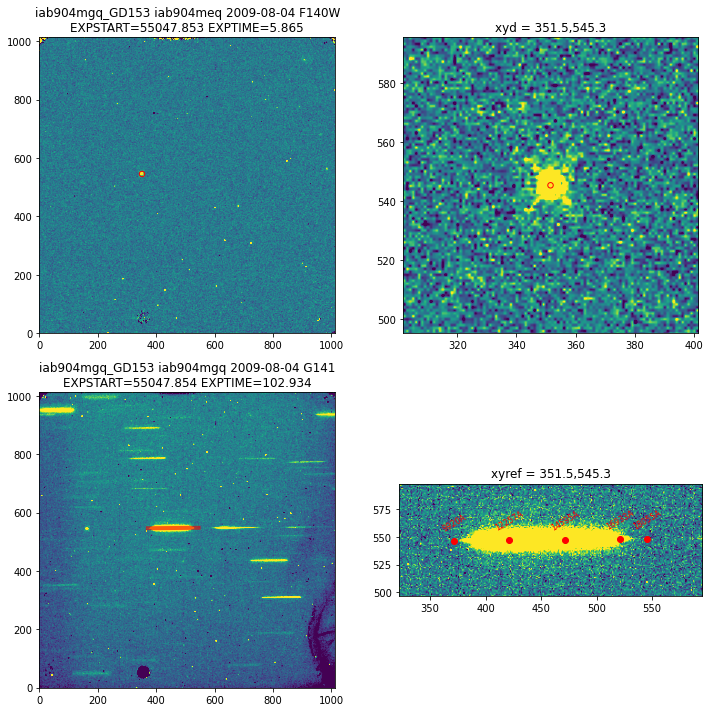

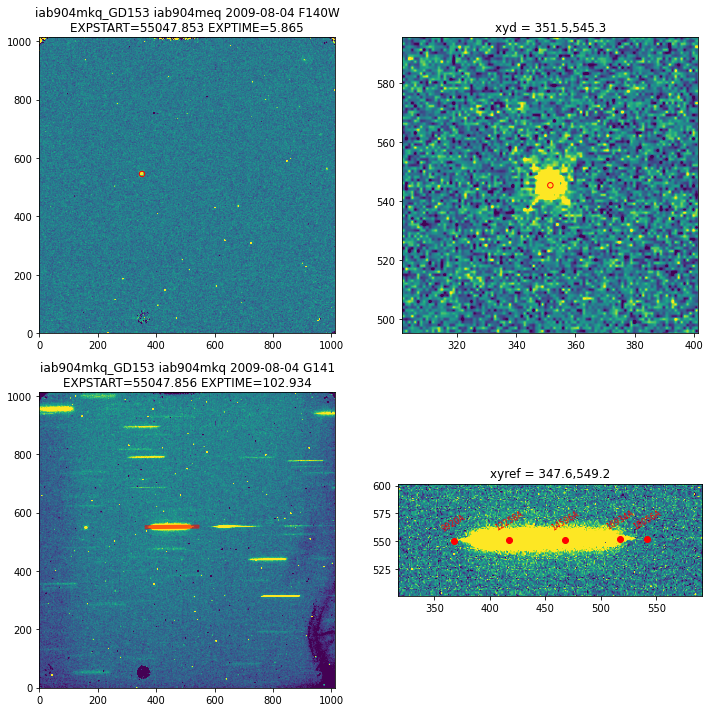

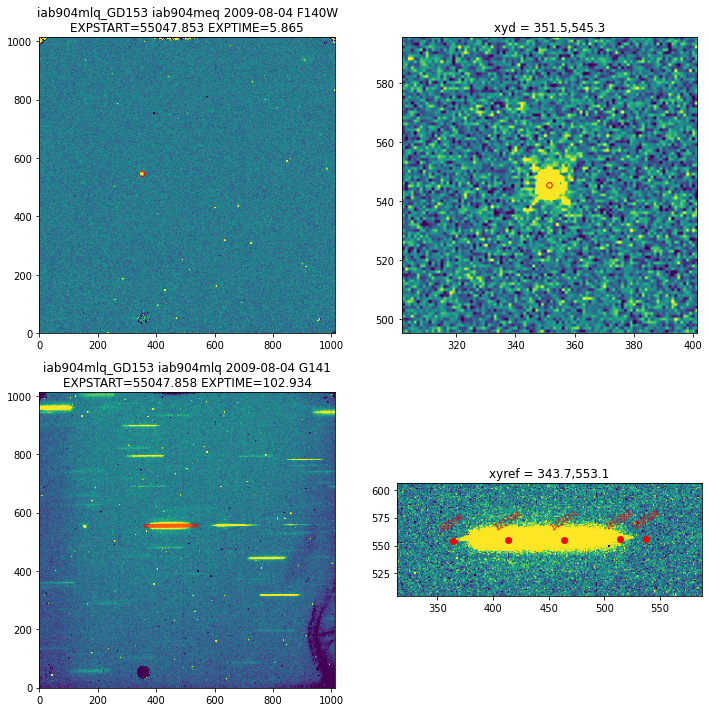

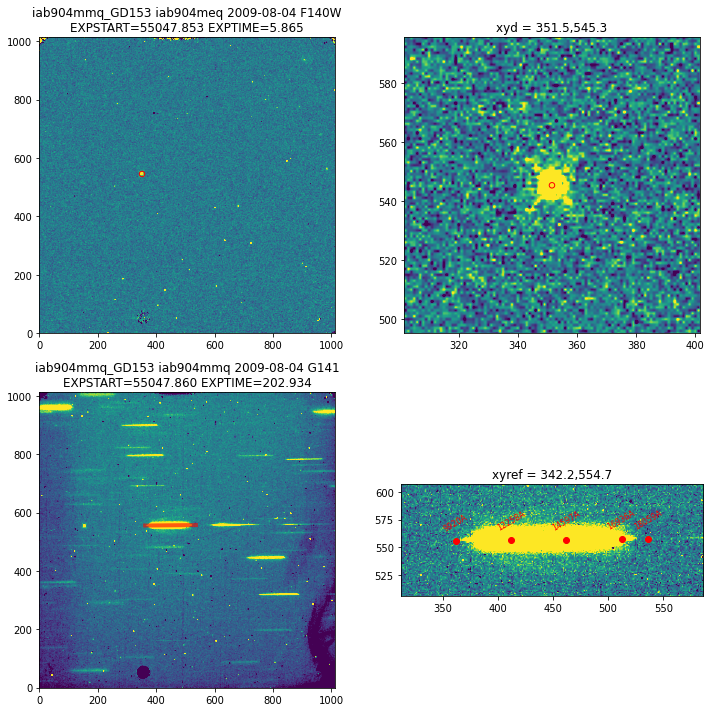

In [16]:
for i,ii in enumerate(flist):
    if i == 0:
        continue
    for j,jj in enumerate(sourcelist):
        if jj != sourcename:
            continue
        dfile = (flist[0],1)
        gfile = (flist[i],1)
        rootname = fits.open(gfile[0])[0].header['ROOTNAME']
        sourcename = jj
        saveprefix = '{0}_{1}'.format(rootname,sourcename)
        savefolder = saveprefix
        plotformat = 'pdf'
        overwrite = False
        x,y = sourcelist[sourcename]
        xyd = (x-1,y-1)
        beam = 'A'
        params_overview = {'figsize': (10, 10), 
                           '221': {'minmax': (5.0, 99.0), 'cmap': 'viridis', 's': 30, 'facecolor': 'None', 'edgecolor': 'red', 'fontsize': 12, 'title': 'default'}, 
                           '222': {'minmax': (5.0, 99.0), 'cmap': 'viridis', 's': 30, 'facecolor': 'None', 'edgecolor': 'red', 'padxy': (50, 50), 'fontsize': 12, 'title': 'default'}, 
                           '223': {'minmax': (5.0, 99.0), 'cmap': 'viridis', 's': 30, 'facecolor': 'None', 'edgecolor': 'red', 'color': 'red', 'ls': '-', 'lw': 4, 'alpha': 0.6, 'fontsize': 12, 'title': 'default'}, 
                           '224': {'minmax': (5.0, 99.0), 'cmap': 'viridis', 's': 30, 'facecolor': 'None', 'edgecolor': 'red', 'color': 'red', 'ls': '-', 'lw': 0, 'alpha': 0.6, 'padxy': (50, 50), 'tickperx': 50, 'annotate_marker': 'ro', 'annotate_color': 'red', 'annotate_fontsize': 8, 'annotate_rotation': 30.0, 'fontsize': 12, 'title': 'default'}}
        generate_flatfield_flt_g141(saveprefix,savefolder,plotformat,overwrite,
                                   xyd,confile,beam,gfile,dfile,
                                   flatfile,
                               params_overview
                                  )


In [17]:
# make drzlist
drzlist = []
for ii,i in enumerate(flist):
    if ii==0:
        continue
    tmp = i.split('/')[-1]
    tmpp = tmp.split('_')[0]
    string = './{0}_{1}/{2}'.format(tmpp,sourcename,tmp)
    drzlist.append(string)
drzlist


['./iab904mgq_GD153/iab904mgq_flt.fits',
 './iab904mkq_GD153/iab904mkq_flt.fits',
 './iab904mlq_GD153/iab904mlq_flt.fits',
 './iab904mmq_GD153/iab904mmq_flt.fits']

In [18]:
# drizzle
params_drz = {'build':True,
          'restore':False,
          'overwrite':False,
          'clean':False,
          # Step 1 Statis Mask
          'static':False,
          # Step 2 Sky Sub
          'skysub':True,
          'skymethod':'localmin',
          'skystat':'median',
          # Step 3 Driz Sep
          'driz_separate':True,
          'driz_sep_kernel':'turbo',
          'driz_sep_pixfrac':1., # Set this high for CR
#           'driz_sep_scale':0.05, # Smaller than native size, better for CR
          # Step 4 Median
          'median':True,
          'combine_type':'median',
          'combine_nhigh':1, # Reject highest values before computing median, good for CR
          # Step 5 Blot
          'blot':True,
          'blot_interp':'poly5',
          'blot_addsky':True,
          # Step 6 CR
          'driz_cr':True,
          'driz_cr_corr':True,
          'driz_cr_ctegrow':0,
          # Step 7 Final Combine
          'driz_combine':True,
              'final_refimage':drzlist[0]
         }
AstroDrizzle(input=drzlist,output=sourcename,**params_drz)


Setting up logfile :  astrodrizzle.log
AstroDrizzle Version 3.1.6 (2020-02-19 16:16:30 -0500) started at: 11:10:53.782 (07/08/2020)

==== Processing Step  Initialization  started at  11:10:53.78 (07/08/2020)

Creating OUTPUT WCS from ./iab904mgq_GD153/iab904mgq_flt.fits[1]
WCS Keywords

CD_11  CD_12: -2.9243570707528e-05 -2.1222998608594e-05
CD_21  CD_22: -2.3663234259257e-05 2.60491438557356e-05
CRVAL    : 194.2556769298195 22.02609672203769
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.13542581245839821
ORIENTAT : -39.17071040057575
********************************************************************************
*
*  Estimated memory usage:  up to 78 Mb.
*  Output image size:       1014 X 1014 pixels. 
*  Output image file:       ~ 11 Mb. 
*  Cores available:         4
*
********************************************************************************
==== Processing Step Initialization finished at 11:10:54.617 (07/08/2020)
==== Processing Step  Static Mask  started at  

==== Processing Step Blot finished at 11:10:58.306 (07/08/2020)
==== Processing Step  Driz_CR  started at  11:10:58.308 (07/08/2020)

Creating output: /Users/kbhirombhakdi/_work/Sidekicks/20200807/iab904mkq_GD153/iab904mkq_sci1_crmask.fits
Creating output: /Users/kbhirombhakdi/_work/Sidekicks/20200807/iab904mgq_GD153/iab904mgq_sci1_crmask.fits
Creating output: /Users/kbhirombhakdi/_work/Sidekicks/20200807/iab904mlq_GD153/iab904mlq_sci1_crmask.fits
Creating output: /Users/kbhirombhakdi/_work/Sidekicks/20200807/iab904mmq_GD153/iab904mmq_sci1_crmask.fits
Created CR corrected file: '/Users/kbhirombhakdi/_work/Sidekicks/20200807/iab904mgq_GD153/iab904mgq_crclean.fits'
Created CR corrected file: '/Users/kbhirombhakdi/_work/Sidekicks/20200807/iab904mkq_GD153/iab904mkq_crclean.fits'
Created CR corrected file: '/Users/kbhirombhakdi/_work/Sidekicks/20200807/iab904mmq_GD153/iab904mmq_crclean.fits'
Created CR corrected file: '/Users/kbhirombhakdi/_work/Sidekicks/20200807/iab904mlq_GD153/iab904mlq_

In [19]:
# setup for drzblot
drzfile = glob.glob('*drz.fits')[0]
reffile = drzlist[0]
skyval = fits.open(reffile)[1].header['MDRIZSKY']
rootname,sourcename = reffile.split('/')[1].split('_')
outdata = './drzblot_{0}/{1}_drzblot_sci.fits'.format(sourcename,rootname)
drzfile,reffile,skyval,outdata

('GD153_drz.fits',
 './iab904mgq_GD153/iab904mgq_flt.fits',
 2.203392028808594,
 './drzblot_GD153/iab904mgq_drzblot_sci.fits')

In [20]:
# facilitate creating folder
saveprefix = rootname
savefolder = 'drzblot_{0}'.format(sourcename)
plotformat = 'pdf'
overwrite = False
containter_drzblot = Container(saveprefix,savefolder,plotformat,overwrite)
# blot
ablot.blot('{0}[1]'.format(drzfile),'{0}[1]'.format(reffile),addsky=False,skyval=skyval,
           outdata=outdata,in_units='counts',out_units='cps')
# replace back
os.system('cp {0} ./{1}/'.format(flist[1],savefolder))
string = './{0}/{1}'.format(savefolder,flist[1].split('/')[-1])
tmp = fits.open(string)
tmpp = fits.open(outdata)
tmp[1].data = tmpp[1].data.copy()
tmp.writeto(string,overwrite=True)


Using coordinate transformation defined by user...
Added 2.203392028808594 counts back in to blotted image as sky.
Created output image: ./drzblot_GD153/iab904mgq_drzblot_sci.fits


# 2. Extract drzblot

In [25]:
halfdy = np.array([0,1,2,3,4,5,6,7,8,9,10,15,20])

/Users/kbhirombhakdi/anaconda3/envs/py3/lib/python3.7/site-packages/hstgrism/container.py:31: UserWarning: Folder drzblot_GD153 already exists. To create a fresh folder, set overwrite = True
  warnings.warn(string)


Save ./drzblot_GD153/drzblot_GD153_xyref.csv
Rescale = False
Perform compute
Rescale = False
Perform compute
Rescale = False
Perform compute
Rescale = False
Perform compute
Save ./drzblot_GD153/drzblot_GD153_trace.csv
Save ./drzblot_GD153/drzblot_GD153_tbox.csv
Save ./drzblot_GD153/drzblot_GD153_bbox.csv
Save ./drzblot_GD153/drzblot_GD153_bbcorner.csv
Save ./drzblot_GD153/drzblot_GD153_cutout.fits
Save ./drzblot_GD153/drzblot_GD153_mask.fits
Save ./drzblot_GD153/drzblot_GD153_overview.pdf



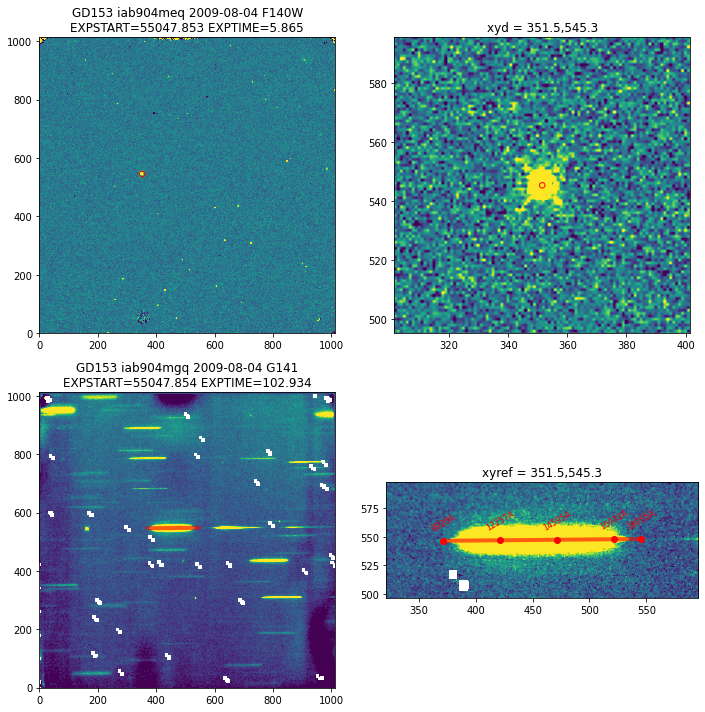

In [31]:
gfile = ('./drzblot_{0}/{1}_flt.fits'.format(sourcename,flist[1].split('/')[-1].split('_')[0]),1)
beam = 'A'
dfile = (flist[0],1)
x,y = sourcelist[sourcename]
xyd = (x-1,y-1)

saveprefix = 'drzblot_{0}'.format(sourcename)
savefolder = saveprefix
plotformat = 'pdf'
overwrite = False
container_params = {'saveprefix':saveprefix,
                    'savefolder':savefolder,
                    'plotformat':plotformat,
                    'overwrite':overwrite
                   }
containerobj = Container(**container_params)

##########
# Compute xyref
##########
xyref_params = {'xyd':xyd,
                'xydiff':'default',
                'xyoff':'default',
                'confile':confile,
                'beam':beam,
                'gfile':gfile,
                'dfile':dfile,
                'container':containerobj
               }
xyrefobj = ComputeXYREF(**xyref_params)
xyrefobj.compute()
xyrefobj.save()
##########
# Map trace and wavelength
##########
xyref = xyrefobj.data['xyref']
grism_params = {'confile':confile,
                'beam':beam,
                'xyref':xyref,
                'container':containerobj
               }
grismobj = WFC3IRG141(**grism_params)
grismobj.compute()
grismobj.save()
##########
# Make cutout
##########
tfile = './{0}/{1}_trace.csv'.format(containerobj.data['savefolder'],containerobj.data['saveprefix'])
tdata = pd.read_csv(tfile)
xg = tdata.xh + tdata.xyref[0]
yg = tdata.yh + tdata.xyref[1]
hdy = halfdy.max()
tbox = {'xg':xg,'yg':yg,'halfdyup':hdy,'halfdylow':hdy}
bbox={'padxleft': 5, 'padxright': 5, 'padyup': 5, 'padylow': 5}
image = fits.open(gfile[0])[gfile[1]].data
do_mask = True
cutoutobj = Cutout2D(tbox,bbox,image,containerobj)
cutoutobj.compute(do_mask)
cutoutobj.save()
##########
# show_overview
##########
show_overview(gfile,dfile,xyd,xyref,grismobj.output['xh'],grismobj.output['yh'],grismobj.output['ww'],
              objname=sourcename,
              save=True,
              container=containerobj,
             )


Save ./drzblot_GD153/drzblot_GD153_bbox.pdf


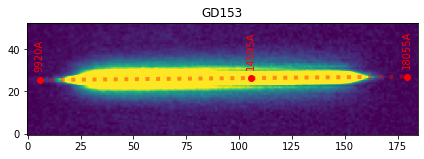

In [32]:
##########
# show_bbox
##########
show_bbox(cutoutdata=cutoutobj.cutout,
          objname=sourcename,
#           maskdata=cutoutobj.mask,
          maskdata=None,
          do_trace=True,
          xcut=xg - cutoutobj.bbcorner['bb0x'],
          ycut=yg - cutoutobj.bbcorner['bb0y'],
          ww=tdata.ww,
          save=True,container=containerobj
         )


Rescale = True

Exclude 0 invalid data points
data_minmax = (0.0,184.0) : scale_minmax = (-1.0,1.0) : method = linear

Exclude 0 invalid data points
data_minmax = (0.0,51.0) : scale_minmax = (-1.0,1.0) : method = linear

Exclude 0 invalid data points
data_minmax = (1.302432894706726,207.09478759765625) : scale_minmax = (-1.0,1.0) : method = linear
Rescale = False
Perform fit
Perform compute
Sigma clipping = False
Save ./iab904mlq_GD153/iab904mlq_GD153_cutbkg.fits
Save ./iab904mlq_GD153/iab904mlq_GD153_maskfit.fits
Save ./iab904mlq_GD153/iab904mlq_GD153_sub.fits


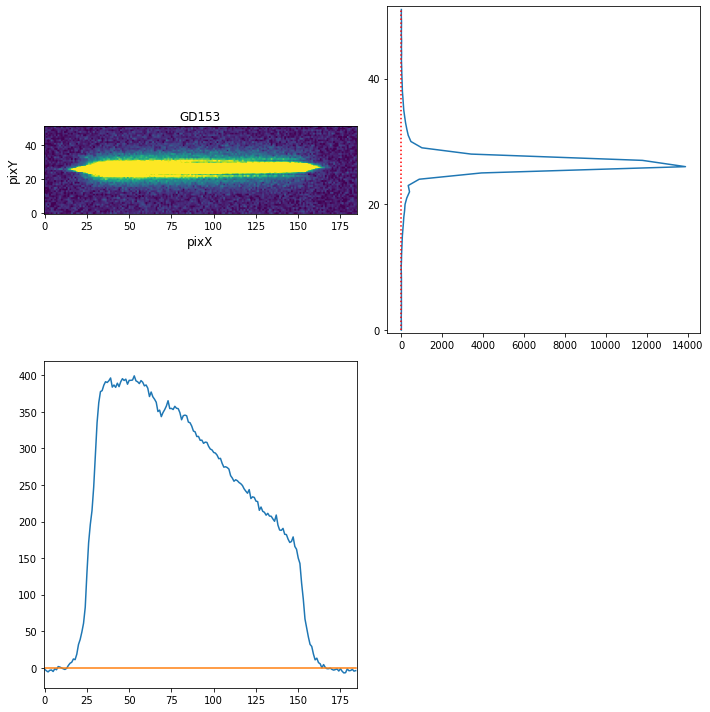

In [37]:
##########
# Background estimation
##########
sfolder,sprefix = containerobj.data['savefolder'],containerobj.data['saveprefix']
gfile = ('./{0}/{1}_cutout.fits'.format(sfolder,sprefix),1)
mfile = ('./{0}/{1}_mask.fits'.format(sfolder,sprefix),1)
gdata = fits.open(gfile[0])[gfile[1]].data
mdata = fits.open(mfile[0])[mfile[1]].data.astype(bool)
norder = 0
sigclip=(False, 5, 1.)
bkgobj = Background(gdata=gdata,norder=norder,mdata=mdata,sigclip=sigclip,container=containerobj)
bkgobj.poly2d.fit()
bkgobj.save(do_yfit=True,do_maskfit=True)
##########
# bkg sub
##########
sfolder,sprefix = containerobj.data['savefolder'],containerobj.data['saveprefix']
gfile = ('./{0}/{1}_cutout.fits'.format(sfolder,sprefix),1)
bfile = ('./{0}/{1}_cutbkg.fits'.format(sfolder,sprefix),1)
bkgsub(gfile,bfile,containerobj)
##########
# show_sum1d
##########
sfile = ('./{0}/{1}_sub.fits'.format(sfolder,sprefix),1)
tmpdata = fits.open(sfile[0])[sfile[1]].data
show_sum1d(gdata=tmpdata,objname=sourcename,mdata=None,do_zero=True,save=False,container=None)


Save ./iab904mlq_GD153/iab904mlq_GD153_halfdy0_mask.fits
Save ./iab904mlq_GD153/iab904mlq_GD153_halfdy1_mask.fits
Save ./iab904mlq_GD153/iab904mlq_GD153_halfdy2_mask.fits
Save ./iab904mlq_GD153/iab904mlq_GD153_halfdy3_mask.fits
Save ./iab904mlq_GD153/iab904mlq_GD153_halfdy4_mask.fits
Save ./iab904mlq_GD153/iab904mlq_GD153_halfdy5_mask.fits
Save ./iab904mlq_GD153/iab904mlq_GD153_halfdy6_mask.fits
Save ./iab904mlq_GD153/iab904mlq_GD153_halfdy7_mask.fits
Save ./iab904mlq_GD153/iab904mlq_GD153_halfdy8_mask.fits
Save ./iab904mlq_GD153/iab904mlq_GD153_halfdy9_mask.fits
Save ./iab904mlq_GD153/iab904mlq_GD153_halfdy10_mask.fits
Save ./iab904mlq_GD153/iab904mlq_GD153_halfdy15_mask.fits
Save ./iab904mlq_GD153/iab904mlq_GD153_halfdy20_mask.fits
Save ./iab904mlq_GD153/iab904mlq_GD153_halfdy0_cps.csv
Save ./iab904mlq_GD153/iab904mlq_GD153_halfdy1_cps.csv
Save ./iab904mlq_GD153/iab904mlq_GD153_halfdy2_cps.csv
Save ./iab904mlq_GD153/iab904mlq_GD153_halfdy3_cps.csv
Save ./iab904mlq_GD153/iab904mlq_GD1

Text(0.5, 1.0, 'drzblot')

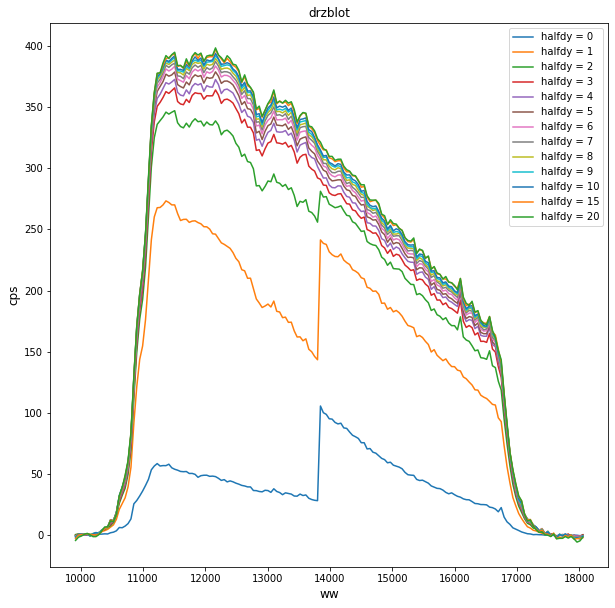

In [38]:
##########
# make mask
##########
sfolder,sprefix = containerobj.data['savefolder'],containerobj.data['saveprefix']
gfile = ('./{0}/{1}_sub.fits'.format(sfolder,sprefix),1)
gdata = fits.open(gfile[0])[gfile[1]]
ny,nx = gdata.shape
trace = './{0}/{1}_trace.csv'.format(sfolder,sprefix)
trace = pd.read_csv(trace)
bbcorner = './{0}/{1}_bbcorner.csv'.format(sfolder,sprefix)
bbcorner = pd.read_csv(bbcorner)
tx = trace.xh + trace.xyref[0] - bbcorner.bb0x[0] 
ty = trace.yh + trace.xyref[1] - bbcorner.bb0y[0]
for i,ii in enumerate(halfdy):
    t = ObjectMask(nx,ny,tx,ty,halfdy[i],halfdy[i])
    t.compute()
    tmpcont = copy.deepcopy(containerobj)
    tmpcont.data['saveprefix'] += '_halfdy{0}'.format(halfdy[i])
    t.save(tmpcont)
#     plt.figure(),plt.imshow(t.mask,origin='lower')

##########
# Extraction
##########
for i,ii in enumerate(halfdy):
    sfolder,sprefix = containerobj.data['savefolder'],containerobj.data['saveprefix']
    gfile = ('./{0}/{1}_sub.fits'.format(sfolder,sprefix),1)
    mfile = ('./{0}/{1}_halfdy{2}_mask.fits'.format(sfolder,sprefix,halfdy[i]),1)
    bbox = pd.read_csv('./{0}/{1}_bbox.csv'.format(sfolder,sprefix))
    trace = pd.read_csv('./{0}/{1}_trace.csv'.format(sfolder,sprefix))
    tbox = pd.read_csv('./{0}/{1}_tbox.csv'.format(sfolder,sprefix))
    instrument = 'HST-WFC3-IR-G102'
    ww = trace.ww.values
    xh = trace.xh.values
    cps = fits.open(gfile[0])[gfile[1]].data
    cps *= fits.open(mfile[0])[mfile[1]].data
    cps = np.nansum(cps,axis=0)[bbox.padxleft[0]:-bbox.padxright[0]]
    output = {'ww':ww,'cps':cps}
    string = './{0}/{1}_halfdy{2}_cps.csv'.format(sfolder,sprefix,halfdy[i])
    pd.DataFrame(output).to_csv(string)
    print('Save {0}'.format(string))
    
##########
# show_cps
##########
plt.figure(figsize=(10,10))
for i,ii in enumerate(halfdy):
    sfolder,sprefix = containerobj.data['savefolder'],containerobj.data['saveprefix']
    string = './{0}/{1}_halfdy{2}_cps.csv'.format(sfolder,sprefix,halfdy[i])
    t = pd.read_csv(string)
    plt.plot(t.ww,t.cps,label='halfdy = {0}'.format(halfdy[i]))
plt.legend()
plt.xlabel('ww',fontsize=12)
plt.ylabel('cps',fontsize=12)
plt.title('drzblot',fontsize=12)

    

# 3. Extract crcorr

In [39]:
crcorrfile = glob.glob('./*q_{0}/*crclean.fits'.format(sourcename))
crcorrfile

['./iab904mkq_GD153/iab904mkq_crclean.fits',
 './iab904mgq_GD153/iab904mgq_crclean.fits',
 './iab904mmq_GD153/iab904mmq_crclean.fits',
 './iab904mlq_GD153/iab904mlq_crclean.fits']

/Users/kbhirombhakdi/anaconda3/envs/py3/lib/python3.7/site-packages/hstgrism/container.py:31: UserWarning: Folder iab904mkq_GD153 already exists. To create a fresh folder, set overwrite = True
  warnings.warn(string)


Save ./iab904mkq_GD153/iab904mkq_GD153_xyref.csv
Rescale = False
Perform compute
Rescale = False
Perform compute
Rescale = False
Perform compute
Rescale = False
Perform compute
Save ./iab904mkq_GD153/iab904mkq_GD153_trace.csv
Save ./iab904mkq_GD153/iab904mkq_GD153_tbox.csv
Save ./iab904mkq_GD153/iab904mkq_GD153_bbox.csv
Save ./iab904mkq_GD153/iab904mkq_GD153_bbcorner.csv
Save ./iab904mkq_GD153/iab904mkq_GD153_cutout.fits
Save ./iab904mkq_GD153/iab904mkq_GD153_mask.fits
Save ./iab904mkq_GD153/iab904mkq_GD153_overview.pdf

Save ./iab904mgq_GD153/iab904mgq_GD153_xyref.csv
Rescale = False
Perform compute
Rescale = False
Perform compute
Rescale = False
Perform compute
Rescale = False
Perform compute
Save ./iab904mgq_GD153/iab904mgq_GD153_trace.csv
Save ./iab904mgq_GD153/iab904mgq_GD153_tbox.csv
Save ./iab904mgq_GD153/iab904mgq_GD153_bbox.csv
Save ./iab904mgq_GD153/iab904mgq_GD153_bbcorner.csv
Save ./iab904mgq_GD153/iab904mgq_GD153_cutout.fits
Save ./iab904mgq_GD153/iab904mgq_GD153_mask.fits

/Users/kbhirombhakdi/anaconda3/envs/py3/lib/python3.7/site-packages/hstgrism/container.py:31: UserWarning: Folder iab904mgq_GD153 already exists. To create a fresh folder, set overwrite = True
  warnings.warn(string)


Save ./iab904mgq_GD153/iab904mgq_GD153_overview.pdf

Save ./iab904mmq_GD153/iab904mmq_GD153_xyref.csv
Rescale = False
Perform compute
Rescale = False
Perform compute
Rescale = False
Perform compute
Rescale = False
Perform compute
Save ./iab904mmq_GD153/iab904mmq_GD153_trace.csv
Save ./iab904mmq_GD153/iab904mmq_GD153_tbox.csv
Save ./iab904mmq_GD153/iab904mmq_GD153_bbox.csv
Save ./iab904mmq_GD153/iab904mmq_GD153_bbcorner.csv
Save ./iab904mmq_GD153/iab904mmq_GD153_cutout.fits
Save ./iab904mmq_GD153/iab904mmq_GD153_mask.fits


/Users/kbhirombhakdi/anaconda3/envs/py3/lib/python3.7/site-packages/hstgrism/container.py:31: UserWarning: Folder iab904mmq_GD153 already exists. To create a fresh folder, set overwrite = True
  warnings.warn(string)


Save ./iab904mmq_GD153/iab904mmq_GD153_overview.pdf

Save ./iab904mlq_GD153/iab904mlq_GD153_xyref.csv
Rescale = False
Perform compute
Rescale = False
Perform compute
Rescale = False
Perform compute
Rescale = False
Perform compute
Save ./iab904mlq_GD153/iab904mlq_GD153_trace.csv
Save ./iab904mlq_GD153/iab904mlq_GD153_tbox.csv
Save ./iab904mlq_GD153/iab904mlq_GD153_bbox.csv
Save ./iab904mlq_GD153/iab904mlq_GD153_bbcorner.csv
Save ./iab904mlq_GD153/iab904mlq_GD153_cutout.fits
Save ./iab904mlq_GD153/iab904mlq_GD153_mask.fits


/Users/kbhirombhakdi/anaconda3/envs/py3/lib/python3.7/site-packages/hstgrism/container.py:31: UserWarning: Folder iab904mlq_GD153 already exists. To create a fresh folder, set overwrite = True
  warnings.warn(string)


Save ./iab904mlq_GD153/iab904mlq_GD153_overview.pdf



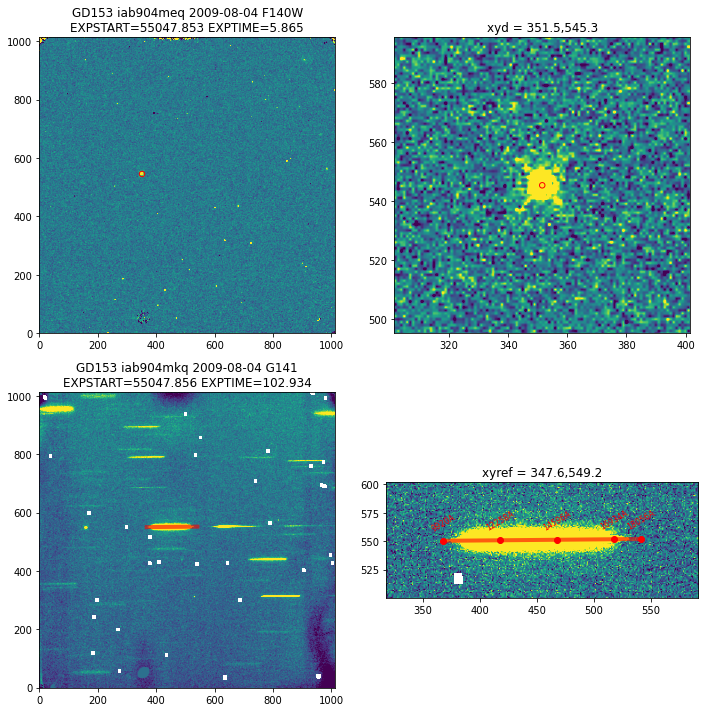

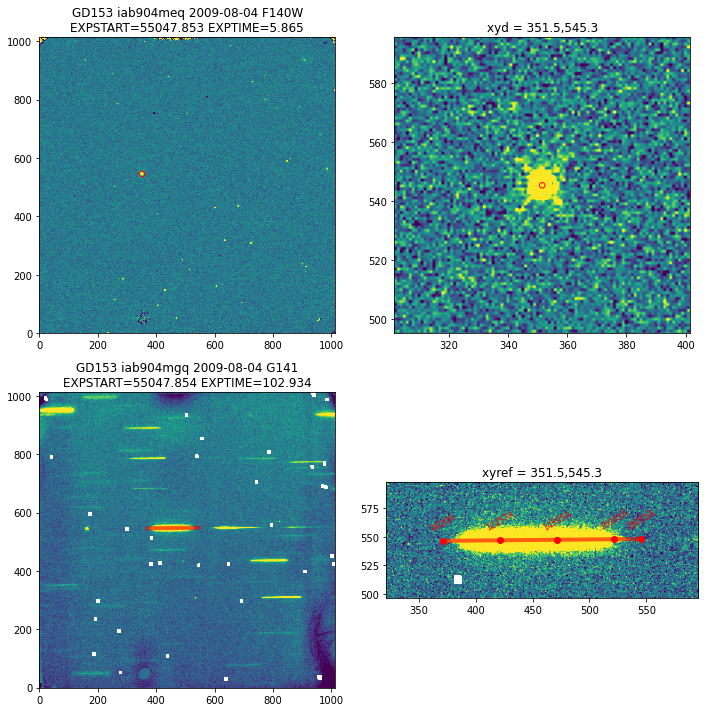

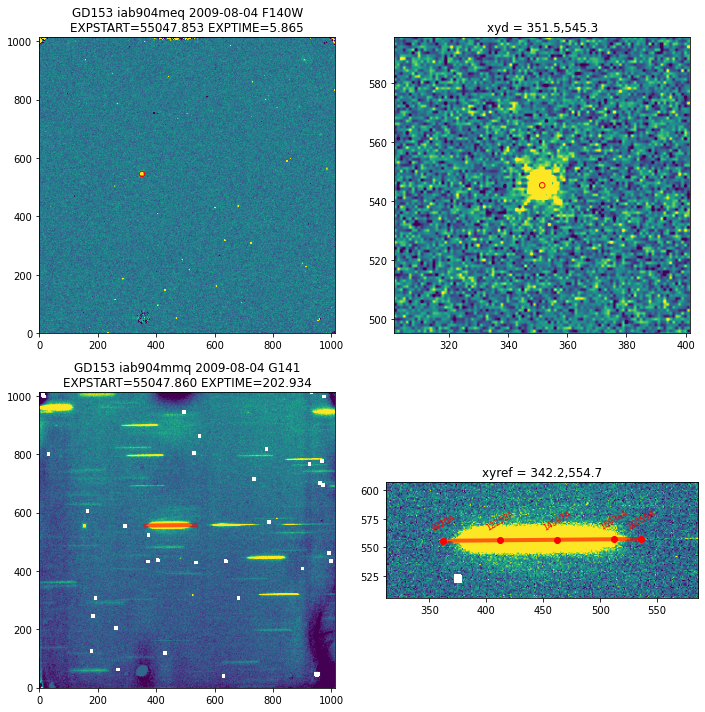

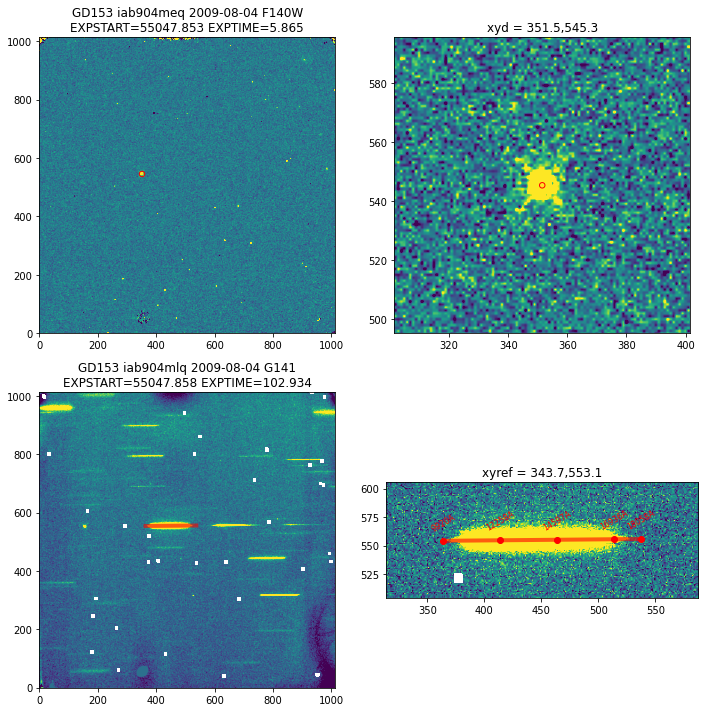

In [40]:
for i,ii in enumerate(crcorrfile):
    gfile = (crcorrfile[i],1)
    beam = 'A'
    x,y = sourcelist[sourcename]
    xyd = (x-1,y-1)

    saveprefix = '{0}_{1}'.format(crcorrfile[i].split('/')[-1].split('_')[0],sourcename)
    savefolder = saveprefix
    plotformat = 'pdf'
    overwrite = False
    container_params = {'saveprefix':saveprefix,
                        'savefolder':savefolder,
                        'plotformat':plotformat,
                        'overwrite':overwrite
                       }
    containerobj = Container(**container_params)

    ##########
    # Compute xyref
    ##########
    xyref_params = {'xyd':xyd,
                    'xydiff':'default',
                    'xyoff':'default',
                    'confile':confile,
                    'beam':beam,
                    'gfile':gfile,
                    'dfile':dfile,
                    'container':containerobj
                   }
    xyrefobj = ComputeXYREF(**xyref_params)
    xyrefobj.compute()
    xyrefobj.save()
    ##########
    # Map trace and wavelength
    ##########
    xyref = xyrefobj.data['xyref']
    grism_params = {'confile':confile,
                    'beam':beam,
                    'xyref':xyref,
                    'container':containerobj
                   }
    grismobj = WFC3IRG141(**grism_params)
    grismobj.compute()
    grismobj.save()
    ##########
    # Make cutout
    ##########
    tfile = './{0}/{1}_trace.csv'.format(containerobj.data['savefolder'],containerobj.data['saveprefix'])
    tdata = pd.read_csv(tfile)
    xg = tdata.xh + tdata.xyref[0]
    yg = tdata.yh + tdata.xyref[1]
    hdy = halfdy.max()
    tbox = {'xg':xg,'yg':yg,'halfdyup':hdy,'halfdylow':hdy}
    bbox={'padxleft': 5, 'padxright': 5, 'padyup': 5, 'padylow': 5}
    image = fits.open(gfile[0])[gfile[1]].data
    do_mask = True
    cutoutobj = Cutout2D(tbox,bbox,image,containerobj)
    cutoutobj.compute(do_mask)
    cutoutobj.save()
    ##########
    # show_overview
    ##########
    show_overview(gfile,dfile,xyd,xyref,grismobj.output['xh'],grismobj.output['yh'],grismobj.output['ww'],
                  objname=sourcename,
                  save=True,
                  container=containerobj,
                 )


/Users/kbhirombhakdi/anaconda3/envs/py3/lib/python3.7/site-packages/hstgrism/container.py:31: UserWarning: Folder iab904mkq_GD153 already exists. To create a fresh folder, set overwrite = True
  warnings.warn(string)
/Users/kbhirombhakdi/anaconda3/envs/py3/lib/python3.7/site-packages/hstgrism/container.py:31: UserWarning: Folder iab904mgq_GD153 already exists. To create a fresh folder, set overwrite = True
  warnings.warn(string)


Rescale = True

Exclude 0 invalid data points
data_minmax = (0.0,184.0) : scale_minmax = (-1.0,1.0) : method = linear

Exclude 0 invalid data points
data_minmax = (0.0,51.0) : scale_minmax = (-1.0,1.0) : method = linear

Exclude 0 invalid data points
data_minmax = (1.311378002166748,210.2311248779297) : scale_minmax = (-1.0,1.0) : method = linear
Rescale = False
Perform fit
Perform compute
Sigma clipping = False
Save ./iab904mkq_GD153/iab904mkq_GD153_cutbkg.fits
Save ./iab904mkq_GD153/iab904mkq_GD153_maskfit.fits
Save ./iab904mkq_GD153/iab904mkq_GD153_sub.fits
Rescale = True

Exclude 0 invalid data points
data_minmax = (0.0,184.0) : scale_minmax = (-1.0,1.0) : method = linear

Exclude 0 invalid data points
data_minmax = (0.0,52.0) : scale_minmax = (-1.0,1.0) : method = linear

Exclude 0 invalid data points
data_minmax = (1.3491300344467163,203.77418518066406) : scale_minmax = (-1.0,1.0) : method = linear
Rescale = False
Perform fit
Perform compute
Sigma clipping = False
Save ./iab904mg

/Users/kbhirombhakdi/anaconda3/envs/py3/lib/python3.7/site-packages/hstgrism/container.py:31: UserWarning: Folder iab904mmq_GD153 already exists. To create a fresh folder, set overwrite = True
  warnings.warn(string)
/Users/kbhirombhakdi/anaconda3/envs/py3/lib/python3.7/site-packages/hstgrism/container.py:31: UserWarning: Folder iab904mlq_GD153 already exists. To create a fresh folder, set overwrite = True
  warnings.warn(string)


Rescale = True

Exclude 0 invalid data points
data_minmax = (0.0,184.0) : scale_minmax = (-1.0,1.0) : method = linear

Exclude 0 invalid data points
data_minmax = (0.0,52.0) : scale_minmax = (-1.0,1.0) : method = linear

Exclude 0 invalid data points
data_minmax = (1.6652741432189941,191.43106079101562) : scale_minmax = (-1.0,1.0) : method = linear
Rescale = False
Perform fit
Perform compute
Sigma clipping = False
Save ./iab904mmq_GD153/iab904mmq_GD153_cutbkg.fits
Save ./iab904mmq_GD153/iab904mmq_GD153_maskfit.fits
Save ./iab904mmq_GD153/iab904mmq_GD153_sub.fits
Rescale = True

Exclude 0 invalid data points
data_minmax = (0.0,184.0) : scale_minmax = (-1.0,1.0) : method = linear

Exclude 0 invalid data points
data_minmax = (0.0,51.0) : scale_minmax = (-1.0,1.0) : method = linear

Exclude 0 invalid data points
data_minmax = (1.302432894706726,207.09478759765625) : scale_minmax = (-1.0,1.0) : method = linear
Rescale = False
Perform fit
Perform compute
Sigma clipping = False
Save ./iab904m

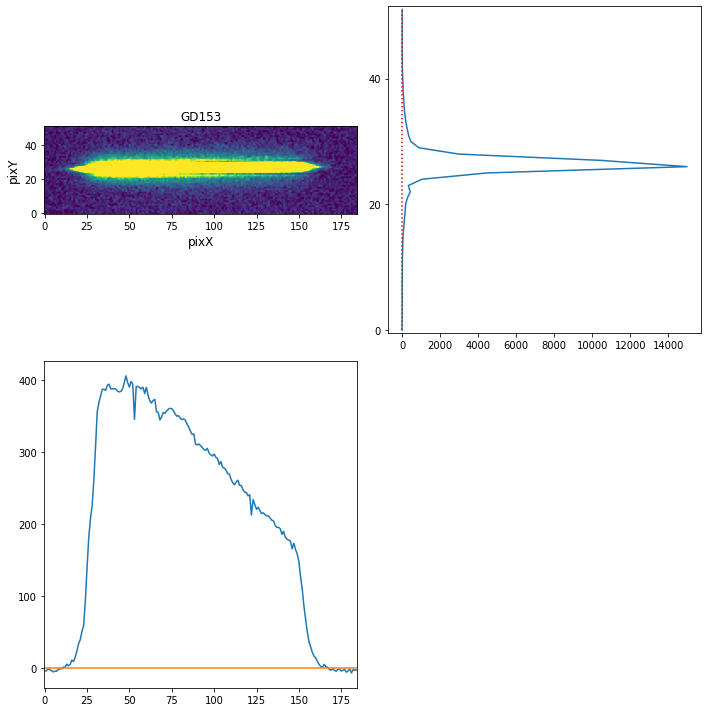

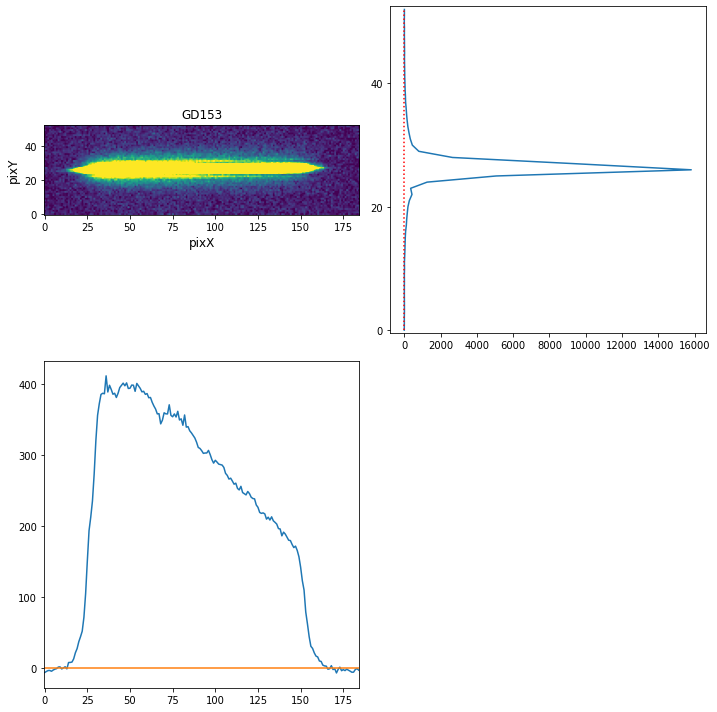

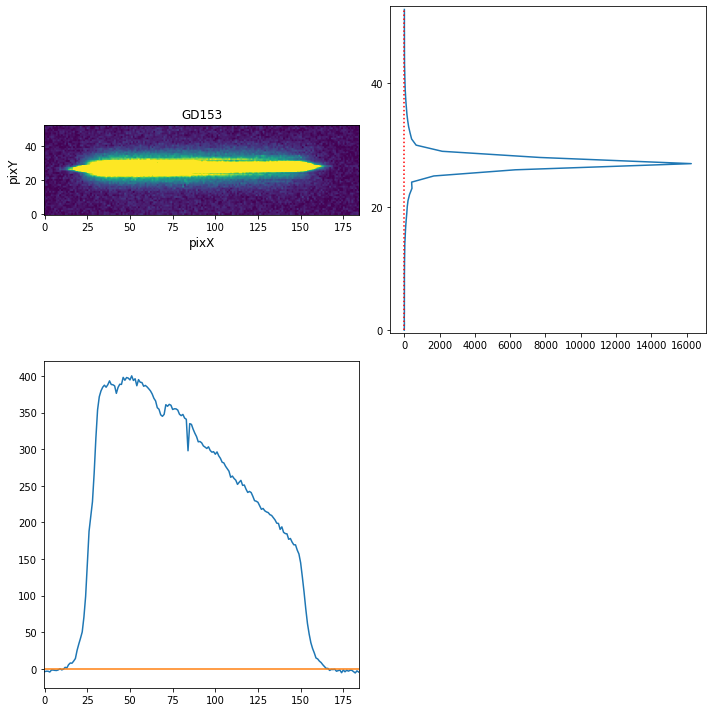

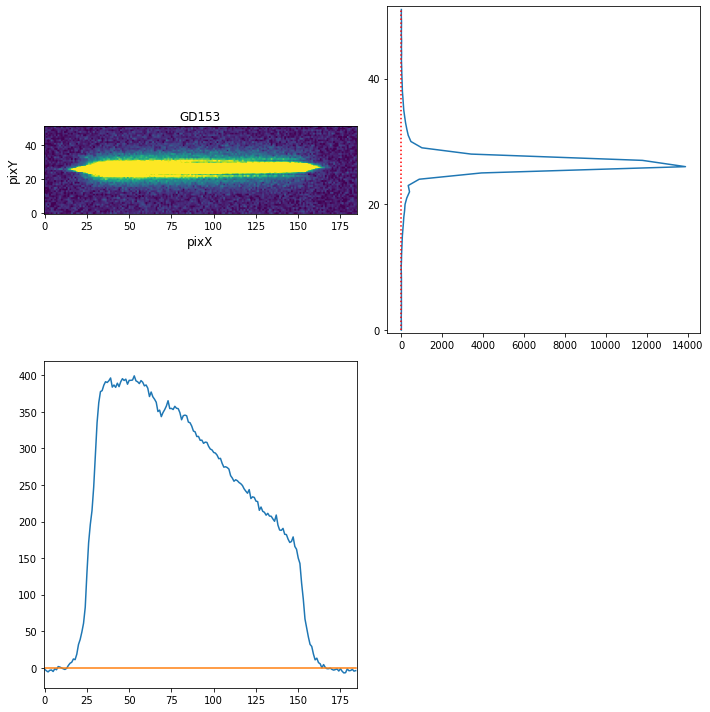

In [41]:
##########
# Background estimation
##########
for i,ii in enumerate(crcorrfile):
    saveprefix = '{0}_{1}'.format(crcorrfile[i].split('/')[-1].split('_')[0],sourcename)
    savefolder = saveprefix
    plotformat = 'pdf'
    overwrite = False
    containerobj = Container(saveprefix,savefolder,plotformat,overwrite)
    sfolder,sprefix = containerobj.data['savefolder'],containerobj.data['saveprefix']
    gfile = ('./{0}/{1}_cutout.fits'.format(sfolder,sprefix),1)
    mfile = ('./{0}/{1}_mask.fits'.format(sfolder,sprefix),1)
    gdata = fits.open(gfile[0])[gfile[1]].data
    mdata = fits.open(mfile[0])[mfile[1]].data.astype(bool)
    norder = 0
    sigclip=(False, 5, 1.)
    bkgobj = Background(gdata=gdata,norder=norder,mdata=mdata,sigclip=sigclip,container=containerobj)
    bkgobj.poly2d.fit()
    bkgobj.save(do_yfit=True,do_maskfit=True)
    ##########
    # bkg sub
    ##########
    sfolder,sprefix = containerobj.data['savefolder'],containerobj.data['saveprefix']
    gfile = ('./{0}/{1}_cutout.fits'.format(sfolder,sprefix),1)
    bfile = ('./{0}/{1}_cutbkg.fits'.format(sfolder,sprefix),1)
    bkgsub(gfile,bfile,containerobj)
    ##########
    # show_sum1d
    ##########
    sfile = ('./{0}/{1}_sub.fits'.format(sfolder,sprefix),1)
    tmpdata = fits.open(sfile[0])[sfile[1]].data
    show_sum1d(gdata=tmpdata,objname=sourcename,mdata=None,do_zero=True,save=False,container=None)


/Users/kbhirombhakdi/anaconda3/envs/py3/lib/python3.7/site-packages/hstgrism/container.py:31: UserWarning: Folder iab904mkq_GD153 already exists. To create a fresh folder, set overwrite = True
  warnings.warn(string)
/Users/kbhirombhakdi/anaconda3/envs/py3/lib/python3.7/site-packages/hstgrism/container.py:31: UserWarning: Folder iab904mgq_GD153 already exists. To create a fresh folder, set overwrite = True
  warnings.warn(string)


Save ./iab904mkq_GD153/iab904mkq_GD153_halfdy0_mask.fits
Save ./iab904mkq_GD153/iab904mkq_GD153_halfdy1_mask.fits
Save ./iab904mkq_GD153/iab904mkq_GD153_halfdy2_mask.fits
Save ./iab904mkq_GD153/iab904mkq_GD153_halfdy3_mask.fits
Save ./iab904mkq_GD153/iab904mkq_GD153_halfdy4_mask.fits
Save ./iab904mkq_GD153/iab904mkq_GD153_halfdy5_mask.fits
Save ./iab904mkq_GD153/iab904mkq_GD153_halfdy6_mask.fits
Save ./iab904mkq_GD153/iab904mkq_GD153_halfdy7_mask.fits
Save ./iab904mkq_GD153/iab904mkq_GD153_halfdy8_mask.fits
Save ./iab904mkq_GD153/iab904mkq_GD153_halfdy9_mask.fits
Save ./iab904mkq_GD153/iab904mkq_GD153_halfdy10_mask.fits
Save ./iab904mkq_GD153/iab904mkq_GD153_halfdy15_mask.fits
Save ./iab904mkq_GD153/iab904mkq_GD153_halfdy20_mask.fits
Save ./iab904mgq_GD153/iab904mgq_GD153_halfdy0_mask.fits
Save ./iab904mgq_GD153/iab904mgq_GD153_halfdy1_mask.fits
Save ./iab904mgq_GD153/iab904mgq_GD153_halfdy2_mask.fits
Save ./iab904mgq_GD153/iab904mgq_GD153_halfdy3_mask.fits
Save ./iab904mgq_GD153/iab90

/Users/kbhirombhakdi/anaconda3/envs/py3/lib/python3.7/site-packages/hstgrism/container.py:31: UserWarning: Folder iab904mmq_GD153 already exists. To create a fresh folder, set overwrite = True
  warnings.warn(string)
/Users/kbhirombhakdi/anaconda3/envs/py3/lib/python3.7/site-packages/hstgrism/container.py:31: UserWarning: Folder iab904mlq_GD153 already exists. To create a fresh folder, set overwrite = True
  warnings.warn(string)


Save ./iab904mlq_GD153/iab904mlq_GD153_halfdy1_mask.fits
Save ./iab904mlq_GD153/iab904mlq_GD153_halfdy2_mask.fits
Save ./iab904mlq_GD153/iab904mlq_GD153_halfdy3_mask.fits
Save ./iab904mlq_GD153/iab904mlq_GD153_halfdy4_mask.fits
Save ./iab904mlq_GD153/iab904mlq_GD153_halfdy5_mask.fits
Save ./iab904mlq_GD153/iab904mlq_GD153_halfdy6_mask.fits
Save ./iab904mlq_GD153/iab904mlq_GD153_halfdy7_mask.fits
Save ./iab904mlq_GD153/iab904mlq_GD153_halfdy8_mask.fits
Save ./iab904mlq_GD153/iab904mlq_GD153_halfdy9_mask.fits
Save ./iab904mlq_GD153/iab904mlq_GD153_halfdy10_mask.fits
Save ./iab904mlq_GD153/iab904mlq_GD153_halfdy15_mask.fits
Save ./iab904mlq_GD153/iab904mlq_GD153_halfdy20_mask.fits
Save ./iab904mkq_GD153/iab904mkq_GD153_halfdy0_cps.csv
Save ./iab904mkq_GD153/iab904mkq_GD153_halfdy1_cps.csv
Save ./iab904mkq_GD153/iab904mkq_GD153_halfdy2_cps.csv
Save ./iab904mkq_GD153/iab904mkq_GD153_halfdy3_cps.csv
Save ./iab904mkq_GD153/iab904mkq_GD153_halfdy4_cps.csv
Save ./iab904mkq_GD153/iab904mkq_GD153

/Users/kbhirombhakdi/anaconda3/envs/py3/lib/python3.7/site-packages/hstgrism/container.py:31: UserWarning: Folder iab904mkq_GD153 already exists. To create a fresh folder, set overwrite = True
  warnings.warn(string)
/Users/kbhirombhakdi/anaconda3/envs/py3/lib/python3.7/site-packages/hstgrism/container.py:31: UserWarning: Folder iab904mkq_GD153 already exists. To create a fresh folder, set overwrite = True
  warnings.warn(string)
/Users/kbhirombhakdi/anaconda3/envs/py3/lib/python3.7/site-packages/hstgrism/container.py:31: UserWarning: Folder iab904mkq_GD153 already exists. To create a fresh folder, set overwrite = True
  warnings.warn(string)
/Users/kbhirombhakdi/anaconda3/envs/py3/lib/python3.7/site-packages/hstgrism/container.py:31: UserWarning: Folder iab904mkq_GD153 already exists. To create a fresh folder, set overwrite = True
  warnings.warn(string)
/Users/kbhirombhakdi/anaconda3/envs/py3/lib/python3.7/site-packages/hstgrism/container.py:31: UserWarning: Folder iab904mkq_GD153 al

/Users/kbhirombhakdi/anaconda3/envs/py3/lib/python3.7/site-packages/hstgrism/container.py:31: UserWarning: Folder iab904mlq_GD153 already exists. To create a fresh folder, set overwrite = True
  warnings.warn(string)
/Users/kbhirombhakdi/anaconda3/envs/py3/lib/python3.7/site-packages/hstgrism/container.py:31: UserWarning: Folder iab904mlq_GD153 already exists. To create a fresh folder, set overwrite = True
  warnings.warn(string)
/Users/kbhirombhakdi/anaconda3/envs/py3/lib/python3.7/site-packages/hstgrism/container.py:31: UserWarning: Folder iab904mlq_GD153 already exists. To create a fresh folder, set overwrite = True
  warnings.warn(string)
/Users/kbhirombhakdi/anaconda3/envs/py3/lib/python3.7/site-packages/hstgrism/container.py:31: UserWarning: Folder iab904mlq_GD153 already exists. To create a fresh folder, set overwrite = True
  warnings.warn(string)
/Users/kbhirombhakdi/anaconda3/envs/py3/lib/python3.7/site-packages/hstgrism/container.py:31: UserWarning: Folder iab904mlq_GD153 al

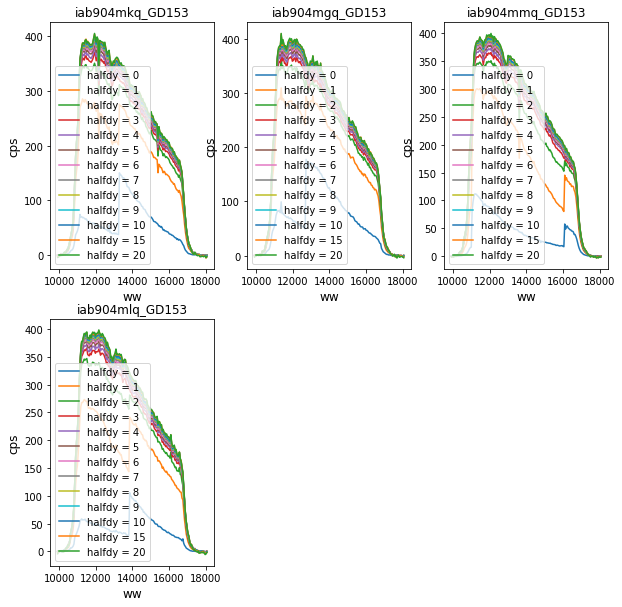

In [42]:
##########
# make mask
##########
for i,ii in enumerate(crcorrfile):
    saveprefix = '{0}_{1}'.format(crcorrfile[i].split('/')[-1].split('_')[0],sourcename)
    savefolder = saveprefix
    plotformat = 'pdf'
    overwrite = False
    containerobj = Container(saveprefix,savefolder,plotformat,overwrite)
    sfolder,sprefix = containerobj.data['savefolder'],containerobj.data['saveprefix']
    gfile = ('./{0}/{1}_sub.fits'.format(sfolder,sprefix),1)
    gdata = fits.open(gfile[0])[gfile[1]]
    ny,nx = gdata.shape
    trace = './{0}/{1}_trace.csv'.format(sfolder,sprefix)
    trace = pd.read_csv(trace)
    bbcorner = './{0}/{1}_bbcorner.csv'.format(sfolder,sprefix)
    bbcorner = pd.read_csv(bbcorner)
    tx = trace.xh + trace.xyref[0] - bbcorner.bb0x[0] 
    ty = trace.yh + trace.xyref[1] - bbcorner.bb0y[0]
    for j,jj in enumerate(halfdy):
        t = ObjectMask(nx,ny,tx,ty,halfdy[j],halfdy[j])
        t.compute()
        tmpcont = copy.deepcopy(containerobj)
        tmpcont.data['saveprefix'] += '_halfdy{0}'.format(halfdy[j])
        t.save(tmpcont)
#         plt.figure(),plt.imshow(t.mask,origin='lower')

##########
# Extraction
##########
for j,jj in enumerate(crcorrfile):
    for i,ii in enumerate(halfdy):
        saveprefix = '{0}_{1}'.format(crcorrfile[j].split('/')[-1].split('_')[0],sourcename)
        savefolder = saveprefix
        plotformat = 'pdf'
        overwrite = False
        containerobj = Container(saveprefix,savefolder,plotformat,overwrite)
        sfolder,sprefix = containerobj.data['savefolder'],containerobj.data['saveprefix']
        gfile = ('./{0}/{1}_sub.fits'.format(sfolder,sprefix),1)
        mfile = ('./{0}/{1}_halfdy{2}_mask.fits'.format(sfolder,sprefix,halfdy[i]),1)
        bbox = pd.read_csv('./{0}/{1}_bbox.csv'.format(sfolder,sprefix))
        trace = pd.read_csv('./{0}/{1}_trace.csv'.format(sfolder,sprefix))
        tbox = pd.read_csv('./{0}/{1}_tbox.csv'.format(sfolder,sprefix))
        instrument = 'HST-WFC3-IR-G102'
        ww = trace.ww.values
        xh = trace.xh.values
        cps = fits.open(gfile[0])[gfile[1]].data
        cps *= fits.open(mfile[0])[mfile[1]].data
        cps = np.nansum(cps,axis=0)[bbox.padxleft[0]:-bbox.padxright[0]]
        output = {'ww':ww,'cps':cps}
        string = './{0}/{1}_halfdy{2}_cps.csv'.format(sfolder,sprefix,halfdy[i])
        pd.DataFrame(output).to_csv(string)
        print('Save {0}'.format(string))
        
##########
# show_cps
##########
fig = plt.figure(figsize=(10,10))
n = len(crcorrfile)
ncol = 3
nrow = int(n/ncol) + 1
for j,jj in enumerate(crcorrfile):
    ax = fig.add_subplot(nrow,ncol,j+1)
    for i,ii in enumerate(halfdy):
        saveprefix = '{0}_{1}'.format(crcorrfile[j].split('/')[-1].split('_')[0],sourcename)
        savefolder = saveprefix
        plotformat = 'pdf'
        overwrite = False
        containerobj = Container(saveprefix,savefolder,plotformat,overwrite)
        sfolder,sprefix = containerobj.data['savefolder'],containerobj.data['saveprefix']
        string = './{0}/{1}_halfdy{2}_cps.csv'.format(sfolder,sprefix,halfdy[i])
        t = pd.read_csv(string)
        plt.plot(t.ww,t.cps,label='halfdy = {0}'.format(halfdy[i]))
    ax.legend()
    ax.set_xlabel('ww',fontsize=12)
    ax.set_ylabel('cps',fontsize=12)
    ax.set_title('{0}'.format(sprefix),fontsize=12)



/Users/kbhirombhakdi/anaconda3/envs/py3/lib/python3.7/site-packages/hstgrism/container.py:31: UserWarning: Folder iab904mkq_GD153 already exists. To create a fresh folder, set overwrite = True
  warnings.warn(string)
/Users/kbhirombhakdi/anaconda3/envs/py3/lib/python3.7/site-packages/hstgrism/container.py:31: UserWarning: Folder iab904mgq_GD153 already exists. To create a fresh folder, set overwrite = True
  warnings.warn(string)
/Users/kbhirombhakdi/anaconda3/envs/py3/lib/python3.7/site-packages/hstgrism/container.py:31: UserWarning: Folder iab904mmq_GD153 already exists. To create a fresh folder, set overwrite = True
  warnings.warn(string)
/Users/kbhirombhakdi/anaconda3/envs/py3/lib/python3.7/site-packages/hstgrism/container.py:31: UserWarning: Folder iab904mlq_GD153 already exists. To create a fresh folder, set overwrite = True
  warnings.warn(string)


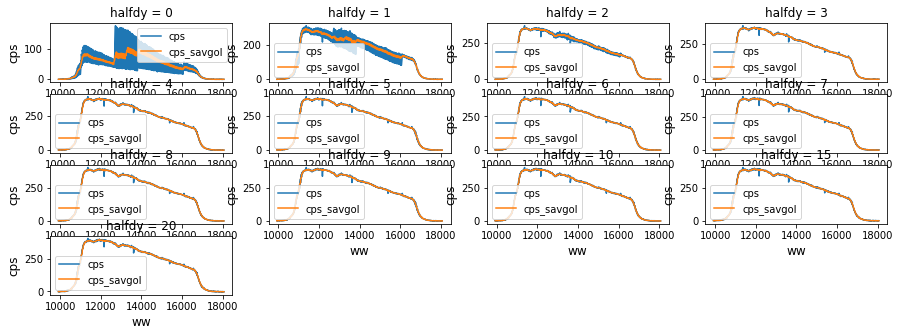

In [43]:
##########
# average
##########
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d

window_length = len(crcorrfile) * 2 + 1
polyorder = 0

cpslist = {}
for i,ii in enumerate(halfdy):
    cpslist[halfdy[i]] = {'ww':None,'cps':None}
    for j,jj in enumerate(crcorrfile):
        saveprefix = '{0}_{1}'.format(crcorrfile[j].split('/')[-1].split('_')[0],sourcename)
        savefolder = saveprefix
        plotformat = 'pdf'
        overwrite = False
        containerobj = Container(saveprefix,savefolder,plotformat,overwrite)
        sfolder,sprefix = containerobj.data['savefolder'],containerobj.data['saveprefix']
        string = './{0}/{1}_halfdy{2}_cps.csv'.format(sfolder,sprefix,halfdy[i])
        if j==0:
            t = pd.read_csv(string)
        else:
            tt = pd.read_csv(string)
            t = pd.concat([t,tt])
    t.sort_values(by=['ww'],inplace=True)
    cpslist[halfdy[i]] = {'ww':t.ww.values.copy(),'cps':t.cps.values.copy()}
    
for i,ii in enumerate(cpslist):
    ww = cpslist[ii]['ww']
    cps = cpslist[ii]['cps']
    t = savgol_filter(cps,window_length=window_length,polyorder=polyorder)
    cpslist[ii]['cps_savgol'] = t.copy()
    
for i,ii in enumerate(cpslist):
    ww = cpslist[ii]['ww']
    cps_savgol = cpslist[ii]['cps_savgol']
    t = interp1d(ww,cps_savgol,kind='linear',bounds_error=False,fill_value=np.nan)
    cpslist[ii]['cps_model'] = copy.deepcopy(t)
    
fig = plt.figure(figsize=(15,5))
n = len(halfdy)
ncol = 4
nrow = int(n/ncol) + 1
for i,ii in enumerate(halfdy):
    ax = fig.add_subplot(nrow,ncol,i+1)
    ax.plot(cpslist[ii]['ww'],cpslist[ii]['cps'],label='cps')
    ax.plot(cpslist[ii]['ww'],cpslist[ii]['cps_savgol'],label='cps_savgol')
    ax.set_xlabel('ww',fontsize=12)
    ax.set_ylabel('cps',fontsize=12)
    ax.set_title('halfdy = {0}'.format(ii),fontsize=12)
    ax.legend()
    

# 3. Compute aperture correction = drzblot / crcorr

In [44]:
drzlist = {}
for i,ii in enumerate(halfdy):
    string = './drzblot_{1}/drzblot_{1}_halfdy{0}_cps.csv'.format(halfdy[i],sourcename)
    t = pd.read_csv(string)
    ww,cps = t.ww.values.copy(),t.cps.values.copy()
    crcorr_model = cpslist[ii]['cps_model'](ww)
    drzlist[halfdy[i]] = {'ww':ww.copy(),'cps':cps.copy(),'crcorr_model':crcorr_model.copy()}


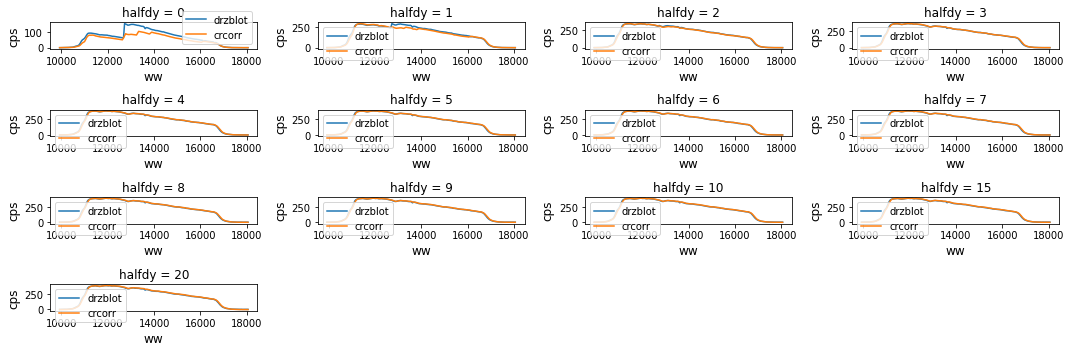

In [45]:
fig = plt.figure(figsize=(15,5))
n = len(halfdy)
ncol = 4
nrow = int(n/ncol) + 1
for i,ii in enumerate(halfdy):
    drz_ww,drz_cps = drzlist[ii]['ww'],drzlist[ii]['cps']
    crcorr_cps = drzlist[ii]['crcorr_model']
    ax = fig.add_subplot(nrow,ncol,i+1)
    ax.plot(drz_ww,drz_cps,label='drzblot')
    ax.plot(drz_ww,crcorr_cps,label='crcorr')
    ax.set_xlabel('ww',fontsize=12)
    ax.set_ylabel('cps',fontsize=12)
    ax.set_title('halfdy = {0}'.format(ii),fontsize=12)
    ax.legend()
fig.tight_layout()


halfdy = 0, median = 2.526E-01
halfdy = 1, median = 5.267E-02
halfdy = 2, median = 1.029E-02
halfdy = 3, median = 5.488E-03
halfdy = 4, median = 6.204E-03
halfdy = 5, median = 6.137E-03
halfdy = 6, median = 6.536E-03
halfdy = 7, median = 6.919E-03
halfdy = 8, median = 7.169E-03
halfdy = 9, median = 7.777E-03
halfdy = 10, median = 8.526E-03
halfdy = 15, median = 1.113E-02
halfdy = 20, median = 1.353E-02


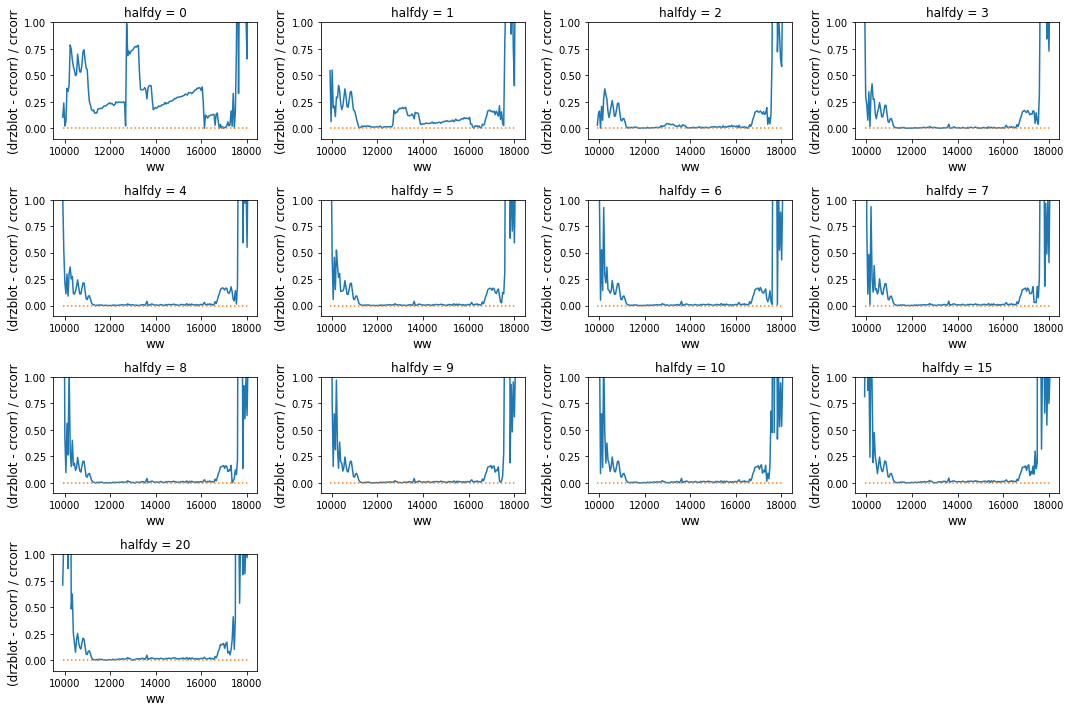

In [48]:
fig = plt.figure(figsize=(15,10))
n = len(halfdy)
ncol = 4
nrow = int(n/ncol) + 1
for i,ii in enumerate(halfdy):
    drz_ww,drz_cps = drzlist[ii]['ww'],drzlist[ii]['cps']
    crcorr_cps = drzlist[ii]['crcorr_model']
    ax = fig.add_subplot(nrow,ncol,i+1)
    t = np.abs((drz_cps - crcorr_cps)/crcorr_cps)
    ax.plot(drz_ww,t)
    ax.plot([drz_ww.min(),drz_ww.max()],[0.,0.],':')
    ax.set_xlabel('ww',fontsize=12)
    ax.set_ylabel('(drzblot - crcorr) / crcorr',fontsize=12)
    ax.set_title('halfdy = {0}'.format(ii),fontsize=12)
    m = np.argwhere((drz_ww >= 11000.) & (drz_ww <= 16500.)).flatten()
    print('halfdy = {0}, median = {1:.3E}'.format(ii,np.median(t[m])))
    ax.set_ylim(-0.1,1.)
fig.tight_layout()


halfdy = 0, median = 1.253E+00
halfdy = 1, median = 1.053E+00
halfdy = 2, median = 1.008E+00
halfdy = 3, median = 9.955E-01
halfdy = 4, median = 9.947E-01
halfdy = 5, median = 9.946E-01
halfdy = 6, median = 9.940E-01
halfdy = 7, median = 9.935E-01
halfdy = 8, median = 9.929E-01
halfdy = 9, median = 9.923E-01
halfdy = 10, median = 9.919E-01
halfdy = 15, median = 9.893E-01
halfdy = 20, median = 9.871E-01


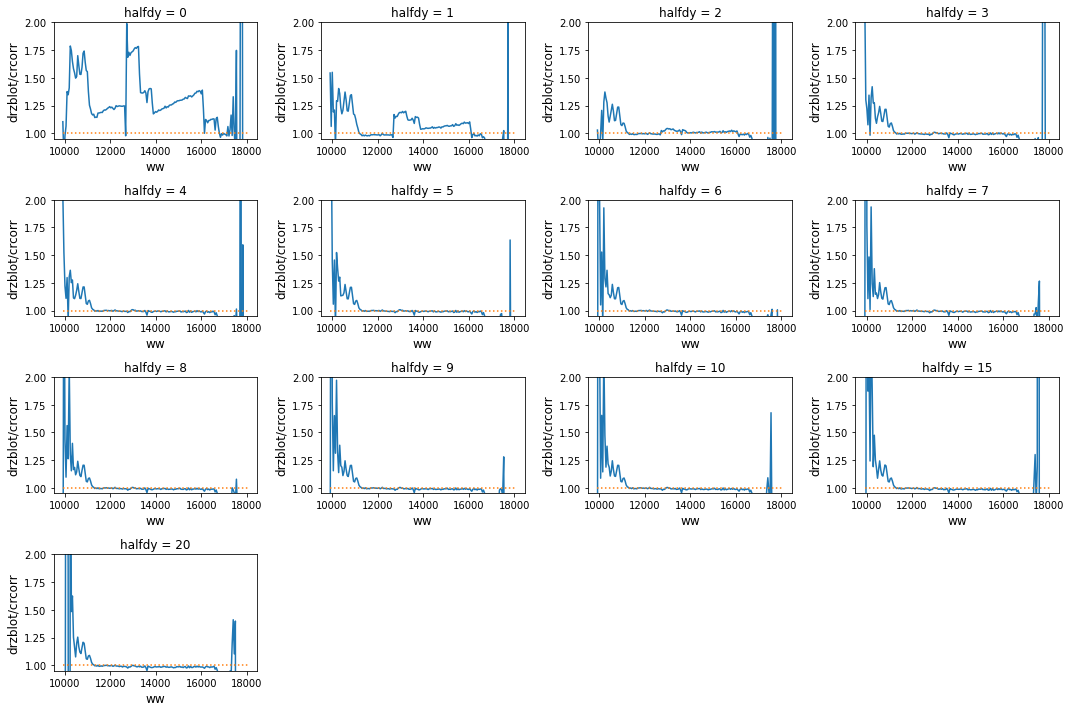

In [49]:
fig = plt.figure(figsize=(15,10))
n = len(halfdy)
ncol = 4
nrow = int(n/ncol) + 1
for i,ii in enumerate(halfdy):
    drz_ww,drz_cps = drzlist[ii]['ww'],drzlist[ii]['cps']
    crcorr_cps = drzlist[ii]['crcorr_model']
    ax = fig.add_subplot(nrow,ncol,i+1)
    t = drz_cps/crcorr_cps
    ax.plot(drz_ww,t)
    ax.plot([drz_ww.min(),drz_ww.max()],[1.,1.],':')
    ax.set_xlabel('ww',fontsize=12)
    ax.set_ylabel('drzblot/crcorr',fontsize=12)
    ax.set_title('halfdy = {0}'.format(ii),fontsize=12)
    ax.set_ylim(0.95,2.)
    m = np.argwhere((drz_ww >= 11000.) & (drz_ww <= 16500.)).flatten()
    print('halfdy = {0}, median = {1:.3E}'.format(ii,np.median(t[m])))
fig.tight_layout()


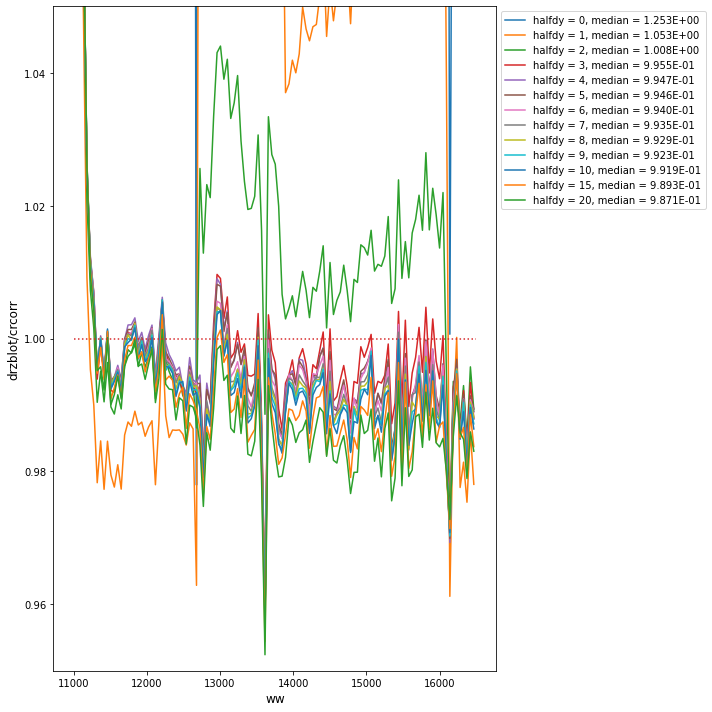

In [52]:
plt.figure(figsize=(10,10))
for i,ii in enumerate(halfdy):
    drz_ww,drz_cps = drzlist[ii]['ww'],drzlist[ii]['cps']
    crcorr_cps = drzlist[ii]['crcorr_model']
    m = np.argwhere((drz_ww >= 11000.) & (drz_ww <= 16500.)).flatten()
    t = drz_cps/crcorr_cps
    plt.plot(drz_ww[m],t[m],label='halfdy = {0}, median = {1:.3E}'.format(ii,np.median(t[m])))
    plt.xlabel('ww',fontsize=12)
plt.plot([11000.,16500.],[1.,1.],':')
plt.ylabel('drzblot/crcorr',fontsize=12)
plt.ylim(0.95,1.05)
plt.legend(bbox_to_anchor=(1., 1.))
plt.tight_layout()


# Summary
Setting halfdy >= 3 pixels would yield drzblot/crcorr < ~1% for GD153. We note that the small scale variation is most likely due to noise. Note that, when going beyond halfdy = 3, we notice the change likely due to noise.
